In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant 

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform

import os
import kagglehub

c:\Users\erika\anaconda3\envs\dsa\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.basic Cleaning and Creating Train/Test Split
1.1 Reading in the data and inspection

In [2]:
# Download latest version
path = kagglehub.dataset_download("xiaomengsun/car-insurance-claim-data")

print("Path to dataset files:", path)
print("Contents:", os.listdir(path))

file_path = os.path.join(path, "car_insurance_claim.csv" )

# Load itt as a DataFrame
raw_data = pd.read_csv(file_path)

#Show the first few rows
pd.set_option('display.max_columns', None)
raw_data.head()

Path to dataset files: C:\Users\erika\.cache\kagglehub\datasets\xiaomengsun\car-insurance-claim-data\versions\1
Contents: ['car_insurance_claim.csv']


,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


### Variables and Descripctions
INDEX - Unique identifier  
TARGET_FLAG - Claim has been made  
TARGET_AMT - Claim value  
AGE - Age of driver  
BLUEBOOK - Value of vehicle  
CAR_AGE - Car age in years  
CAR_TYPE Type of vehicle  
CLM_FRQ - Number of claims in past 5 years  
EDUCATION - Highest level of education completed by policyholder  
HOMEKIDS - NUmber of child at policyholder's address  
HOME_VAL -  vALUE OF POLICYHOLDER'S HOME  
INCOME - Income of policy holder  
JOB - Type of job held by policyholder  
KIDSDRIV - Number of children with access to policyholder's vehicle  
MSTATUS - marital status  
OLDCLAIM - Total value of claims in part 5 years  
PARENT1 - Single parent  
RED_CAR - Vehicle is red in colour  
REVOKED - Licence has been revoked in past 7 years  
SEX - Gender  
TIF -  Policy tenure  
TRAVTIME - Commute distance  
URVANCITY - Address area type (urban/rural)  
TOJ - Years polyholder's job has been held for  

We don't want to fundamentely change any data as we still not split our data into a test/train set. So we want to avoid any data leakage

#### 1.2 Basic Data Cleaning 


In [3]:
# Create new copy of data
data_df = raw_data.copy()

In [4]:
# define updated column names
col_names = {
       'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'commute_dist',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'

}

# Update col names
data_df.rename(columns = col_names, inplace = True)


In [5]:
# Summary the data
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10302 non-null  int64  
 1   num_young_drivers          10302 non-null  int64  
 2   date_of_birth              10302 non-null  object 
 3   age                        10295 non-null  float64
 4   num_of_children            10302 non-null  int64  
 5   years_job_held_for         9754 non-null   float64
 6   income                     9732 non-null   object 
 7   single_parent              10302 non-null  object 
 8   value_of_home              9727 non-null   object 
 9   married                    10302 non-null  object 
 10  gender                     10302 non-null  object 
 11  highest_education          10302 non-null  object 
 12  occupation                 9637 non-null   object 
 13  commute_dist               10302 non-null  int

In [6]:
# Check for duplicate records
data_df.duplicated().sum()

np.int64(1)

In [7]:
# Drop duplicates
data_df.drop_duplicates(inplace=True)

In [8]:
# Define currency cols
currency_cols = ['income', 'value_of_home', 'vehicle_value', '5_year_total_claims_value', 'new_claim_value']

# Create function to remove '$' and ','
def format_currency_cols(data, cols):
    for col in cols:
        data[col] = data[col].replace('[\\$,]', "", regex = True).astype('Int64')
    return data

data_df = format_currency_cols(data_df, currency_cols)


In [9]:
data_df.columns

Index(['ID', 'num_young_drivers', 'date_of_birth', 'age', 'num_of_children',
       'years_job_held_for', 'income', 'single_parent', 'value_of_home',
       'married', 'gender', 'highest_education', 'occupation', 'commute_dist',
       'type_of_use', 'vehicle_value', 'policy_tenure', 'vehicle_type',
       'red_vehicle', '5_year_total_claims_value', '5_year_num_of_claims',
       'licence_revoked', 'license_points', 'new_claim_value', 'vehicle_age',
       'is_claim', 'address_type'],
      dtype='object')

In [10]:
data_df.head()

,ID,num_young_drivers,date_of_birth,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,63581743,0,16MAR39,60.0,0,11.0,67349,No,0,z_No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,91449,No,257252,z_No,M,z_High School,z_Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,52881,No,0,z_No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,16039,No,124191,Yes,z_F,z_High School,Clerical,5,Private,4010,4,z_SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,z_Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [11]:
# Define cols that have prefix
z_prefix_cols = ['married', 'gender', 'highest_education', 'occupation', 'vehicle_type', 'address_type']

# Create a function to remove 'z_' prefix
def remove_prefix(data, cols):
    for col in cols:
        data[col] = data[col].replace('[z_]', '', regex = True)
    return data

data_df = remove_prefix(data_df, z_prefix_cols)




In [12]:
data_df.head()

,ID,num_young_drivers,date_of_birth,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,63581743,0,16MAR39,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [13]:
# Drop features we don't need
data_df.drop(['ID', 'date_of_birth'], axis = 1, inplace = True)

In [14]:
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


when creating our sets, we want to make sure there's no bias in the negative or positive classes. So that the sets are actually reprsentative of the customer data. To be clear, when I say the positive and negative classes I'm referring to the Target variable which in this project for the classification is the "is_claim" feature. The positive class is that the customer has made a claim and the negative class that they haven't made a claim. Since we have a feature that describes a claim value of customers that have claimed we can use this to do something called stratified sampling. This will avoid bias in the test set.  
We can create bins based on non-zero values for the claim value as thsi implies indirectly that the 'is_claim' feature is true, but we can double check this to make sure our assumptions is correct.

1.3 Create Train/Test Split

In [15]:
# Check there are no non-zero values for 'new_claim_value' where 'is_claim' = 1
mask = (data_df['new_claim_value'] > 0 ) & (data_df['is_claim'] ==0)
data_df[mask]

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type


In [16]:
# Create histoplot for new Claim values

fig = px.histogram(data_df, x="new_claim_value", nbins = 10)
fig.show()


We can see that this shows a heavy  right skew. So when creating our strata bins it might be wise to create nonlinearly spaced bins to better capture the moer extreme values with few instances.

In [17]:
# Define bins
bins = list(range(0, 50001, 5000 )) + [np.inf]

# Define bin labels
labels = np.arange(1,12)

# Apply bins using cut
data_df['claim_value_cat'] = pd.cut(data_df['new_claim_value'], bins = bins, labels = labels, include_lowest= True)

In [18]:
bins

[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, inf]

<Axes: ylabel='claim_value_cat'>

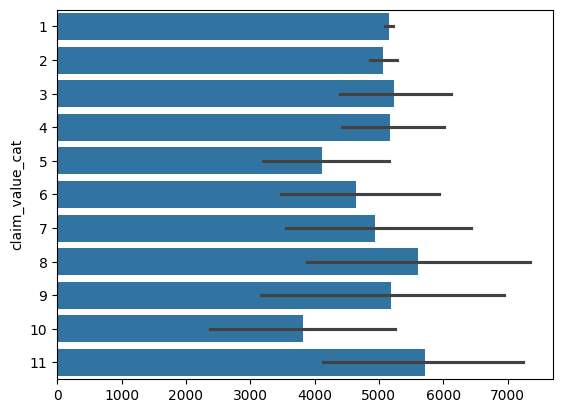

In [19]:
sns.barplot(data_df['claim_value_cat'])

It's improtant t ohave a sufficient number of each stratum in the data set or else the estimate of each stratum's importance might be biased

In [20]:
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type,claim_value_cat
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban,1
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban,1
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban,1
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban,1
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban,1


In [21]:
# Show distributions with barplot
df = data_df['claim_value_cat'].value_counts().sort_values().reset_index()
df.columns = ['claim_value_cat', 'count']


fig = px.bar(df, x='claim_value_cat', y = 'count')
fig.show()

In [22]:
# Create copy of data
X = data_df.copy()
y = data_df['is_claim']

# Drop target features from X
X.drop(columns = ['new_claim_value', 'is_claim'], inplace = True)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=42, stratify = X['claim_value_cat'])
# Stratify argument is to stritify sampling 

In [23]:
# Check positive/negativa class ratio for y_train and y_test
# Quick check to make sure that the positive and n egative classes for ther target distribution in the test set are 
# representative of the train set. We can easily do this by summing instances were true is equal to 1 and falses is equal to zero.
# And then dividing by t he total a number of instances
train_ratio = round((y_train.sum()/len(y_train))*100,2)
test_ratio = round(y_test.sum()/len(y_test)*100,2)

print(f'train positive class ration : {train_ratio}%')
print(f'Test positive class ration: {test_ratio}%')

train positive class ration : 26.48%
Test positive class ration: 27.37%


In [24]:
# Remove bins from each set
for set_ in (X_train, X_test):
    set_.drop(columns = ['claim_value_cat'], inplace= True)

#### 2. Exploratory Data Analysis (EDA)
2.1 Preparation

In [25]:
# For the purpose of exploring our correlations between predictiors and the target variable
# We are joining X_train and y_train so that we have the predictors and the target variabole in the same dataframe
# As some of the features are categorical, we won~t be able to look at their correlation with this claim
# We can make some changes to the binary categorical columns to easily fix this
# Create new copy of X_train for analysis
eda_test_data = X_train.copy()
eda_test_data['is_claim'] = y_train

In [26]:
# Define binary cols
# I'll create a list that defines the binary columns then create a map that updates theses values from text
# to zeros or ones

# Define binary cols
binary_cols = ['single_parent', 'married', 'gender', 'red_vehicle', 'licence_revoked']

# Define map values
mapping = { 'Yes' : 1,
           'No' : 0,
           'yes' : 1,
           'no' : 0,
           'M' : 1,
           'F' : 0}

# Define function to binarize features
def binarize_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

# Call function
eda_test_data = binarize_values(eda_test_data, binary_cols, mapping)

In [27]:
# Check updated values
eda_test_data.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type,is_claim
8452,0,57.0,0,NaN,33707,0,0,0,0,<High School,Blue Collar,40,Private,7200,10,SUV,0,0,0,0,1,1.0,Highly Rural/ Rural,0
7822,2,41.0,3,14.0,17321,0,109835,1,0,<High School,Blue Collar,24,Private,6530,4,Sports Car,0,0,0,0,3,1.0,Highly Urban/ Urban,0
1312,0,29.0,2,12.0,54310,1,174139,0,1,<High School,Clerical,39,Private,1500,4,Minivan,0,5419,1,0,5,6.0,Highly Urban/ Urban,1
921,0,46.0,1,13.0,62886,1,202178,0,0,Bachelors,Professional,18,Private,22260,1,Minivan,0,5290,1,0,6,6.0,Highly Urban/ Urban,0
8708,0,39.0,0,8.0,115182,0,312887,1,1,High School,Professional,25,Commercial,5400,1,Pickup,0,0,0,0,1,5.0,Highly Urban/ Urban,0


2.2.Correlation matrix

In [28]:
# We can now go ahead and investigate how each of our features correlates with is claim feature
corr_matrix = eda_test_data.corr(numeric_only = True).sort_values(['is_claim'], ascending = True)

In [29]:
corr_matrix_no_claim = corr_matrix.drop('is_claim')

<Axes: >

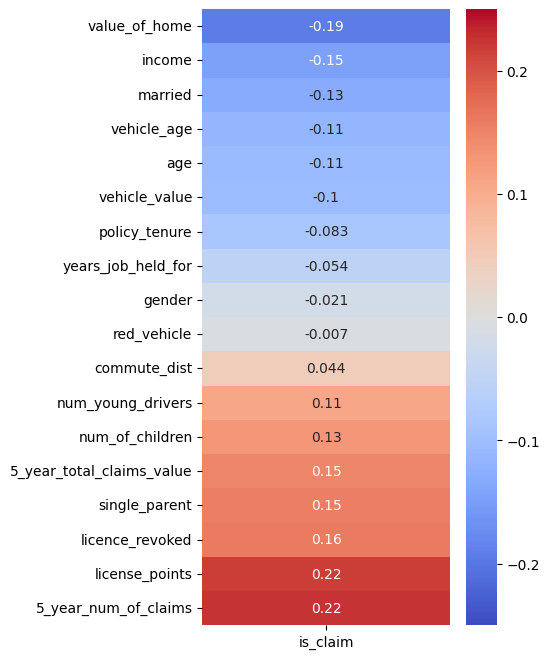

In [30]:
# Create a heatmap
fig, ax = plt.subplots(figsize = (4,8))
sns.heatmap(corr_matrix_no_claim[['is_claim']], cmap= 'coolwarm', annot= True, vmax = 0.25, vmin = -0.25)

We can't infer causation but we can speculate. The total number of claims in the past 5 years might suggest that the more a person is claimed in the past the more likely they might be are to claim again in the future. With license poinst, the more points they have might suggest a lower quality of driving and might reflect their likelihood to claim again in the future. Then looking at the strongest negative correlation, we can see that home value is the strongest and income the next strongest . We can also see in the center, with very negligible correlationthe red vehicle feature. It could be somthing of an urban myth that relates to red cars and that they're more likely to be involved in accidents, but we can see from our data at least that doesn't appear to be true.

### 3. Dta Cleaning and Preprocessing
3.1 Dropping Features

In [31]:
X_train_raw = X_train.copy()

# Define cols to drop
cols_to_drop = ['red_vehicle']

# Drop cols
X_train_raw.drop(columns = cols_to_drop, axis = 1, inplace = True)

### 3.2. Handling Missing values


In [32]:
# Check the number of missing values 
X_train_raw.isnull().sum().sum()

np.int64(2418)

In [33]:
# Check how many missingg values by feature
X_train_raw.isnull().sum()


num_young_drivers              0
age                            5
num_of_children                0
years_job_held_for           433
income                       474
single_parent                  0
value_of_home                462
married                        0
gender                         0
highest_education              0
occupation                   527
commute_dist                   0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
license_points                 0
vehicle_age                  517
address_type                   0
dtype: int64

In [34]:
# For the numerical features using a simple imputer with a strategy like mean or median might be too naive for our model 
# We can try be a bit more intelligent and use a k nearest neighbors imputer or knn imputer
# the k nearest neighbors imputer will take the nearest information it has available ans interpolate to input a value

# Create imputer
knn_inputer = KNNImputer(n_neighbors=2)

# Define the numerical cols
numerical_cols_df = X_train_raw.select_dtypes(include = ['number'])
numerical_cols = numerical_cols_df.columns.tolist()

# Define the categorical cols to use later
cat_cols_df = X_train_raw.select_dtypes(include = ['object'])
cat_cols = cat_cols_df.columns.tolist()

In [35]:
#  Define function to inpute numerical features using KNN
def num_knn_impute(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Call function to impute values
num_test_data_imputed = num_knn_impute(X_train_raw, numerical_cols, knn_inputer)


In [36]:
# Get numerical cols as a df
num_cols_df = X_train_raw[numerical_cols].reset_index(drop = True)

# Select rows with missing values and show head
missing_data_df = num_cols_df[num_cols_df.isna().any(axis = 1)]
missing_data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0,57.0,0,NaN,33707,0,40,7200,10,0,0,1,1.0
11,0,36.0,2,13.0,19934,<NA>,17,10790,6,7797,2,9,1.0
19,0,59.0,0,11.0,123969,347418,35,31540,1,0,0,1,NaN
25,0,51.0,0,7.0,141546,351285,18,29330,4,1184,2,4,NaN
28,1,51.0,1,8.0,<NA>,253662,5,12430,1,9000,1,0,11.0


In [37]:
# Show same records as above but after imputation 
samples = missing_data_df.index.to_list()
num_test_data_imputed.loc[samples].head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0
11,0.0,36.0,2.0,13.0,19934.0,158778.5,17.0,10790.0,6.0,7797.0,2.0,9.0,1.0
19,0.0,59.0,0.0,11.0,123969.0,347418.0,35.0,31540.0,1.0,0.0,0.0,1.0,8.5
25,0.0,51.0,0.0,7.0,141546.0,351285.0,18.0,29330.0,4.0,1184.0,2.0,4.0,7.0
28,1.0,51.0,1.0,8.0,67333.0,253662.0,5.0,12430.0,1.0,9000.0,1.0,0.0,11.0


Categorical feature imputation

In [38]:
# For the categorical value, I'm gonan use a simpel imputer and inpute the most common value
simple_imputer = SimpleImputer(strategy = 'most_frequent')

# Define function to impute cat features using simple imputer
def cat_simple_imputer(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Call fucntion to impute cat features
cat_test_ata_imputed = cat_simple_imputer(X_train_raw, cat_cols, simple_imputer)



In [39]:
# Get categorical cols as a df
cat_cols_df = X_train_raw[cat_cols].reset_index(drop = True)

# Select rows with missing values and show head
cat_missing_data_df = cat_cols_df[cat_cols_df.isna().any(axis = 1)]
cat_missing_data_df.head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
19,No,Yes,M,Masters,NaN,Commercial,Panel Truck,No,Highly Urban/ Urban
36,No,Yes,F,Masters,NaN,Commercial,Van,No,Highly Urban/ Urban
69,Yes,No,M,Masters,NaN,Commercial,Van,No,Highly Urban/ Urban
77,No,No,M,Masters,NaN,Commercial,Pickup,No,Highly Rural/ Rural
78,No,Yes,M,PhD,NaN,Commercial,Panel Truck,No,Highly Rural/ Rural


In [40]:
# Show same records as above but after imputation 
samples = cat_missing_data_df.index.to_list()
cat_test_ata_imputed.loc[samples].head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
19,No,Yes,M,Masters,Blue Collar,Commercial,Panel Truck,No,Highly Urban/ Urban
36,No,Yes,F,Masters,Blue Collar,Commercial,Van,No,Highly Urban/ Urban
69,Yes,No,M,Masters,Blue Collar,Commercial,Van,No,Highly Urban/ Urban
77,No,No,M,Masters,Blue Collar,Commercial,Pickup,No,Highly Rural/ Rural
78,No,Yes,M,PhD,Blue Collar,Commercial,Panel Truck,No,Highly Rural/ Rural


Rejoin numerical and categorical ata following imputation

In [41]:
# Rejoin dfs
train_imputed_df = pd.concat([num_test_data_imputed, cat_test_ata_imputed], axis = 1)

# Check data
train_imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0,No,Yes,F,<High School,Blue Collar,Private,Sports Car,No,Highly Urban/ Urban
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,Yes,No,M,<High School,Clerical,Private,Minivan,No,Highly Urban/ Urban
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,Yes,No,F,Bachelors,Professional,Private,Minivan,No,Highly Urban/ Urban
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0,No,Yes,M,High School,Professional,Commercial,Pickup,No,Highly Urban/ Urban


In [42]:
train_imputed_df.isnull().sum()

num_young_drivers            0
age                          0
num_of_children              0
years_job_held_for           0
income                       0
value_of_home                0
commute_dist                 0
vehicle_value                0
policy_tenure                0
5_year_total_claims_value    0
5_year_num_of_claims         0
license_points               0
vehicle_age                  0
single_parent                0
married                      0
gender                       0
highest_education            0
occupation                   0
type_of_use                  0
vehicle_type                 0
licence_revoked              0
address_type                 0
dtype: int64

We now need to look at encoding our categorical features. Most machine learning algorithms need numerical data to work with, so we need to convert our text based categorical data t o numerical values. That's essentially all encoding is but there's several methods to do that. 

#### 3.4. Categorical Features Encoding

In [43]:
cat_test_ata_imputed.nunique()

single_parent        2
married              2
gender               2
highest_education    5
occupation           8
type_of_use          2
vehicle_type         6
licence_revoked      2
address_type         2
dtype: int64

We can see that msot of the features has 2 unique values, this means that we can just consider these as binary values, zero or one.
Highest education has 5 different values, and it's improtante to note here that they do have an order or ranking. So gettinga PhD for instance is a higher ranking than graduating to high School. The presence of this ranking means that this is an ordinal feature and this isn't true for all categorical features. 
For example, occupation has eight unique values, but thre's no ranking or order to them. The same is true for car type, for these non-binary non-ordinal features we need to do something called one hot encoding.
One hot encoding creates a new column or feature for each uniqeu value of existing feature only one of these new features that's created is equal to one, and hence why it's called one hot encoding. So we can use one hot encoding for occupation and car type and we use ordinal encoding for highest education level. The remaining categorical features we use binary encoding.

In [44]:
#  Define ordinal features
cat_cols_ord = ['highest_education']
# Define finary features
cat_cols_bin = ['single_parent', 'married', 'gender', 'type_of_use', 'licence_revoked', 'address_type']
# Define one-hot features
cat_cols_one_hot = ['occupation', 'vehicle_type']

In [45]:
# Create encoders

# First define education rank/order
education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# Define ordinal encoder
ord_encoder = OrdinalEncoder(categories = education_rank)

# Define binary encoder
bin_encoder = OrdinalEncoder()

# Define one-hot encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

Fit/transform encoders

In [46]:
# Encode ordinals
ord_encoded = ord_encoder.fit_transform(cat_test_ata_imputed[cat_cols_ord])

# Encode binaries
bin_encoded = bin_encoder.fit_transform(cat_test_ata_imputed[cat_cols_bin])

# Encode with one-hot
one_hot_encoded = one_hot_encoder.fit_transform(cat_test_ata_imputed[cat_cols_one_hot])

In [47]:
# Create dfs for each array
ord_encoded_df = pd.DataFrame(ord_encoded)
ord_encoded_df.columns = cat_cols_ord

bin_encoded_df = pd.DataFrame(bin_encoded)
bin_encoded_df.columns = cat_cols_bin

one_hot_encoded_df = pd.DataFrame(one_hot_encoded)
one_hot_encoded_df.columns = one_hot_encoder.get_feature_names_out()

# Joina ll encoded dfs to a sinlge
all_cat_encoded_df = pd.concat([ord_encoded_df, bin_encoded_df, one_hot_encoded_df], axis = 1)
all_cat_encoded_df.head()



,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [48]:
# Bring numerical and categorical data back together
X_train_cleaned = pd.concat([train_imputed_df[numerical_cols], all_cat_encoded_df], axis = 1)



In [49]:
X_train_cleaned.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Check if we've fallen into the dummy variable trap. This is really common when using one hot encoding and oaccurs because one of the new features that's been created is redundant and causes perfect multicolinearity. In simple terms, knowing all of the values for one hot encode features allows you to perfectly predict the remainingg one. 

Check dumym variable trap

In [50]:
# Function to calculate Variance Inflation Feature
def calculte_vif(dataframe):
    # Add constant to df
    df_with_constant = add_constant(dataframe)

    # Calculte VIF for each feature
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df_with_constant.columns
    vif_data['VIF'] = [variance_inflation_factor(df_with_constant.values, i) for i in range(df_with_constant.shape[1])]

    return vif_data

# Calculate VIF
vif_df = calculte_vif(X_train_cleaned)
vif_df

c:\Users\erika\anaconda3\envs\dsa\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\erika\anaconda3\envs\dsa\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide



,Feature,VIF
0,const,0.000000
1,num_young_drivers,1.317458
2,age,1.470704
3,num_of_children,2.083100
4,years_job_held_for,1.437881
5,income,2.633292
6,value_of_home,2.120414
7,commute_dist,1.039162
8,vehicle_value,2.030342
9,policy_tenure,1.005861


We can see all our hot encode feature show inf as a result, which is not what  we want. It means all thesse features has perfect multicolinearity. Generally speaking a vif of five or below is acceptable. There's a simple solution to this and that's just to drop one of the features the one hot coding created. These features are often referred to as dummy variables or dummy features. Dropping one of these dummy features is often referred to as dropping the reference or baseline category. 

In [51]:
X_train_cleaned.columns

Index(['num_young_drivers', 'age', 'num_of_children', 'years_job_held_for',
       'income', 'value_of_home', 'commute_dist', 'vehicle_value',
       'policy_tenure', '5_year_total_claims_value', '5_year_num_of_claims',
       'license_points', 'vehicle_age', 'highest_education', 'single_parent',
       'married', 'gender', 'type_of_use', 'licence_revoked', 'address_type',
       'occupation_Blue Collar', 'occupation_Clerical', 'occupation_Doctor',
       'occupation_Home Maker', 'occupation_Lawyer', 'occupation_Manager',
       'occupation_Professional', 'occupation_Student', 'vehicle_type_Minivan',
       'vehicle_type_Panel Truck', 'vehicle_type_Pickup', 'vehicle_type_SUV',
       'vehicle_type_Sports Car', 'vehicle_type_Van'],
      dtype='object')

In [52]:
# Drop reference category of one hot encoded features
X_train_cleaned.drop(['occupation_Blue Collar', 'vehicle_type_Minivan'], axis = 1, inplace = True)

In [53]:
# Check VIF again
vif_df = calculte_vif(X_train_cleaned)
vif_df

,Feature,VIF
0,const,80.124998
1,num_young_drivers,1.317458
2,age,1.470704
3,num_of_children,2.083100
4,years_job_held_for,1.437881
5,income,2.633292
6,value_of_home,2.120414
7,commute_dist,1.039162
8,vehicle_value,2.030342
9,policy_tenure,1.005861


We can now see all our features are well below five, which is what we wanted to see

### 5. model Selection - Classification

In [54]:
# Define classifiers to test 
clfs = [
    ('Logistic Regression', LogisticRegression(solver = 'liblinear', max_iter = 2000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(random_state = 42)),
    ('Linear SVM', LinearSVC(random_state= 42, max_iter= 1000, dual = 'auto')),
    ('XGBoost', XGBClassifier(random_state = 42)),
    ('AdaBoost', AdaBoostClassifier(random_state= 42, algorithm= 'SAMME')),
    ('Gradient Boost', GradientBoostingClassifier(random_state= 42)),
    ('Bagging', BaggingClassifier(random_state = 42)),
    ('CatBoost', CatBoostClassifier(random_state = 42, verbose = 0))
]

When we teste these models, we wnat to use cross validation. This is a good method for checking that the data has not been overfit. Cross validation essentially splits the data into a number of groups you define and thesse are colled folds. It then reserves one of these folds for testing and uses all of the others for training. By then averaging out the performance across each evalutaion you get much better idea of the performance of the model versus just a single test. So we can use the same folds for esach test with each classifier.

In [55]:
# Create a KFold object
kf = KFold(n_splits= 10, shuffle = True, random_state= 42)

# Dictionary to store results
results = {}

# Evaluate each classifier using cross-validation
for clf_name, clf in clfs:
    cv_scores = cross_val_score(clf, X_train_cleaned, y_train, cv = kf)
    results[clf_name] = cv_scores

cv_scores_df = pd.DataFrame(results)

c:\Users\erika\anaconda3\envs\dsa\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.

c:\Users\erika\anaconda3\envs\dsa\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.

c:\Users\erika\anaconda3\envs\dsa\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.

c:\Users\erika\anaconda3\envs\dsa\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.

c:\Users\erika\anaconda3\envs\dsa\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in

Text(0.5, 1.0, 'Cross-Validation Scores for Different Classifiers')

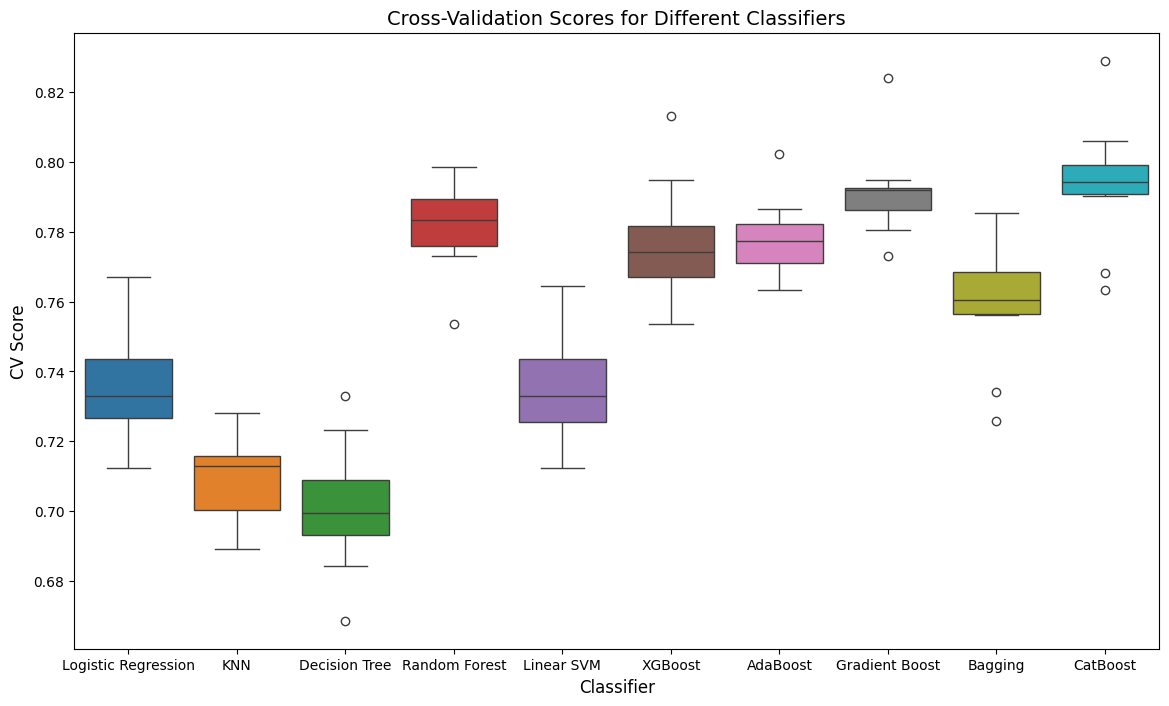

In [56]:
# Plot scores
fig, ax = plt.subplots(figsize = (14,8))
sns.boxplot(cv_scores_df)

# Add axis labels
ax.set_xlabel('Classifier', fontsize = 12)
ax.set_ylabel('CV Score', fontsize = 12)
ax.set_title('Cross-Validation Scores for Different Classifiers', fontsize = 14)

I'm gonna proceed with the XG Boostt model for this analysis. I found the tuning the hyper parameters of XG Boost is much faster than other models and this is better suited for this analysis. We'll start by looking at some feature engineering now. The feature engineering that you wnat to use is ofter guided by the model that you want to use. For example, some models like non-boosting models benefit from feature scaling, but other mdoels like boost models and tree based models don't benefit from feature scaling as they're far less sensitive to it. 

#### 6. Feature Engineering

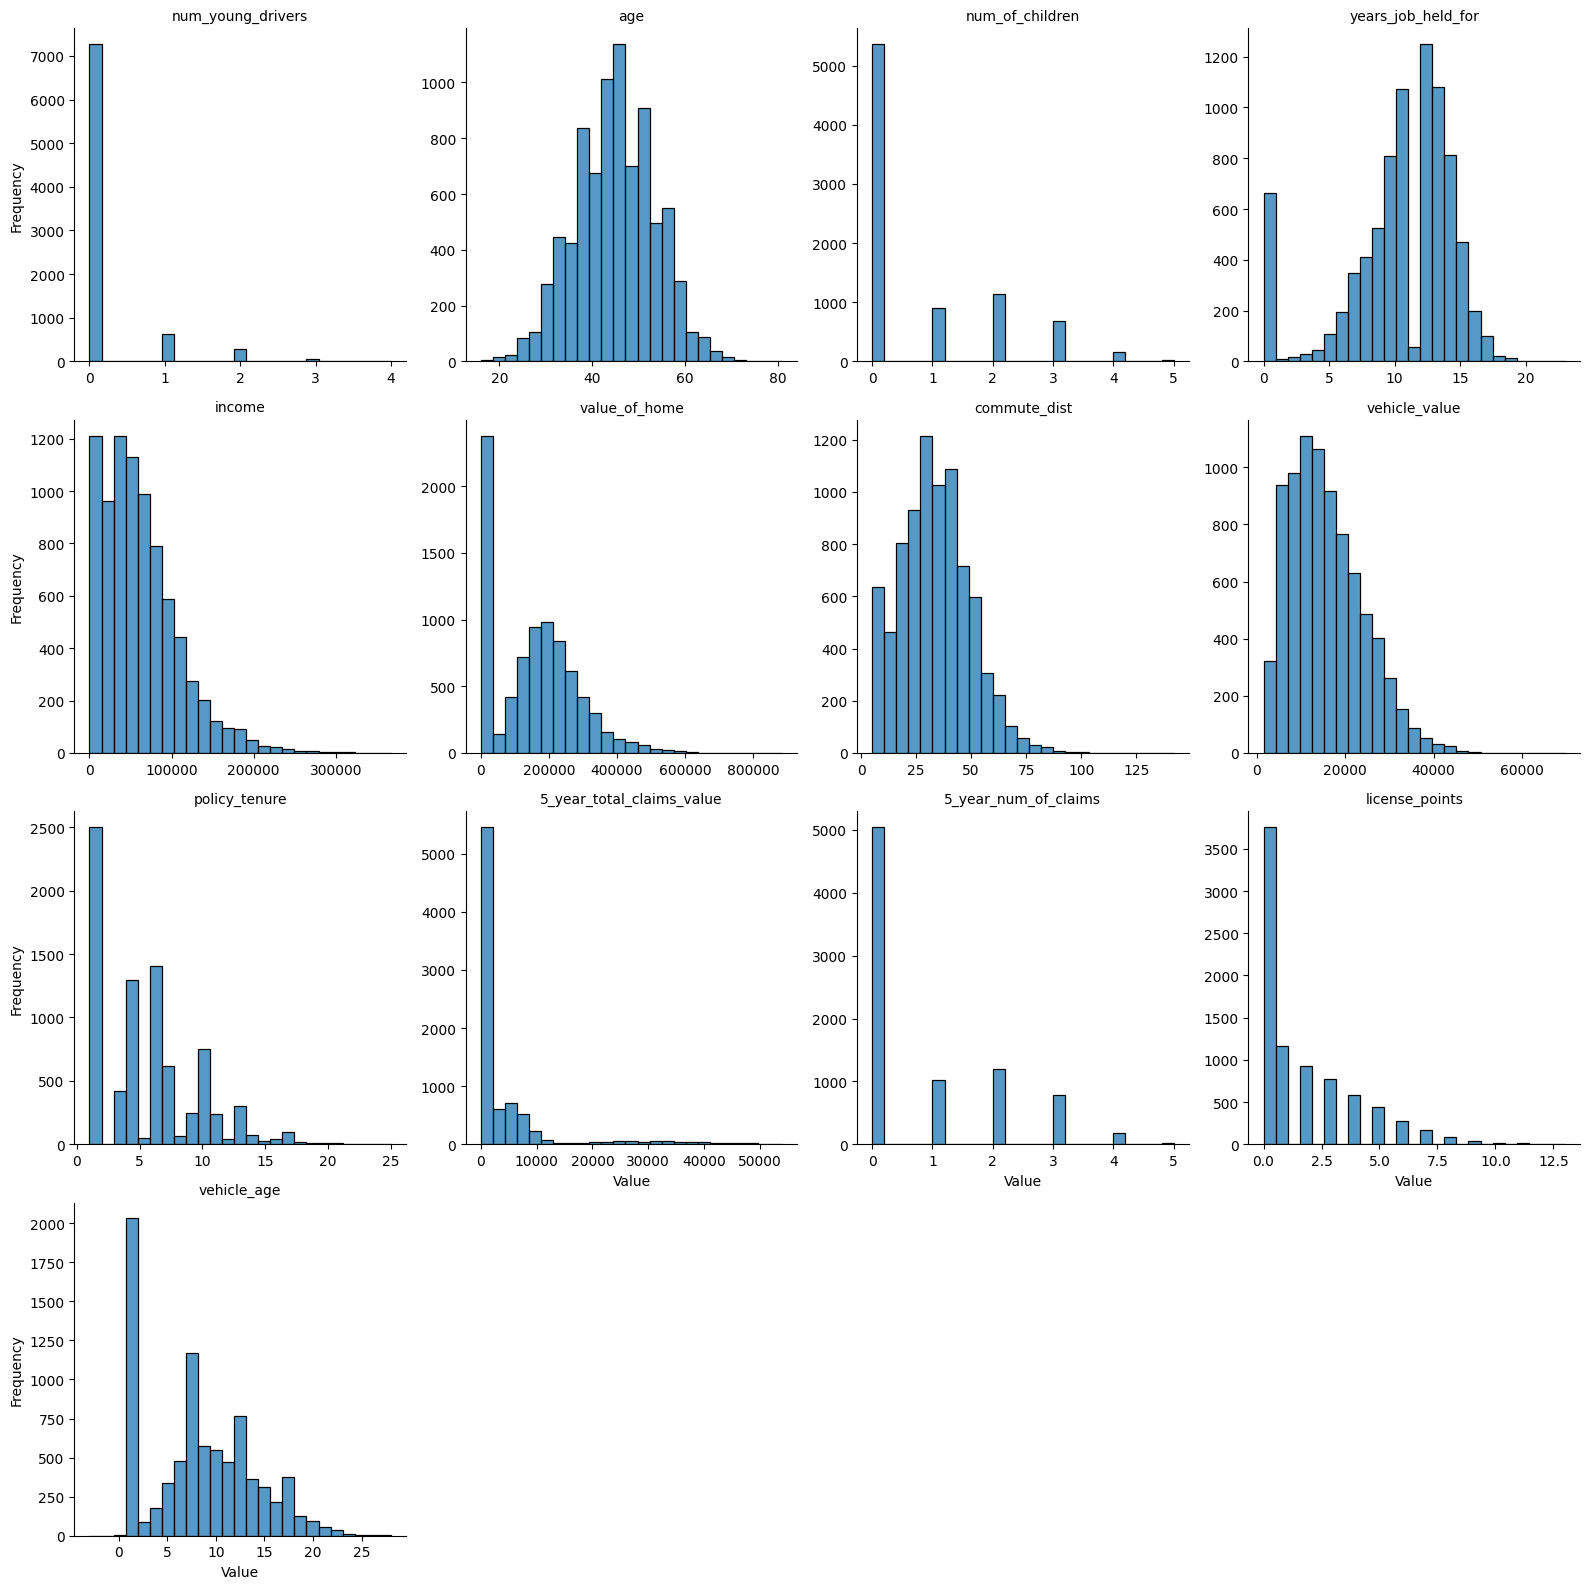

In [57]:
# Plot numerical feature distributions

# Melt df to long format
melted_X_train = X_train_cleaned[numerical_cols].melt(var_name = 'Column', value_name = 'Value')

# Create sns facetgrid
g = sns.FacetGrid(melted_X_train, col = 'Column', col_wrap = 4, sharex = False, sharey = False, height = 4)

# Map sns histoplot to each facet
g.map(sns.histplot, 'Value', bins = 25)

# Add titles and labels
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template = '{col_name}')

plt.tight_layout()

With most machine learnign models it's desirable to have a roughly symmetrical distribution. Immediately we can notice that some of our features have a right skew to them, namely income, value of home, commute distance, vehicle value, policy tenure and license points. If the features had really long tails we might want to take the log of the feature. If the tails aren't too long a common way to make distribution symmetrical  is to take a square root of the feature. So let's tru takinthe swuare root of these features and see if we can improve the performance of the model.

In [58]:
# Define right-skewed features 
skewed_features = ['income', 'value_of_home', 'commute_dist', 'vehicle_value', 'policy_tenure', 'license_points']

# Define function to take sqrt of values
def sqrt_of_feature(data_df, skewed_features):
    data = data_df.copy()
    for feature in skewed_features:
        data[feature] = np.sqrt(data[feature])
    return data

# Call function
X_train_cleaned_sqrt = sqrt_of_feature(X_train_cleaned, skewed_features)

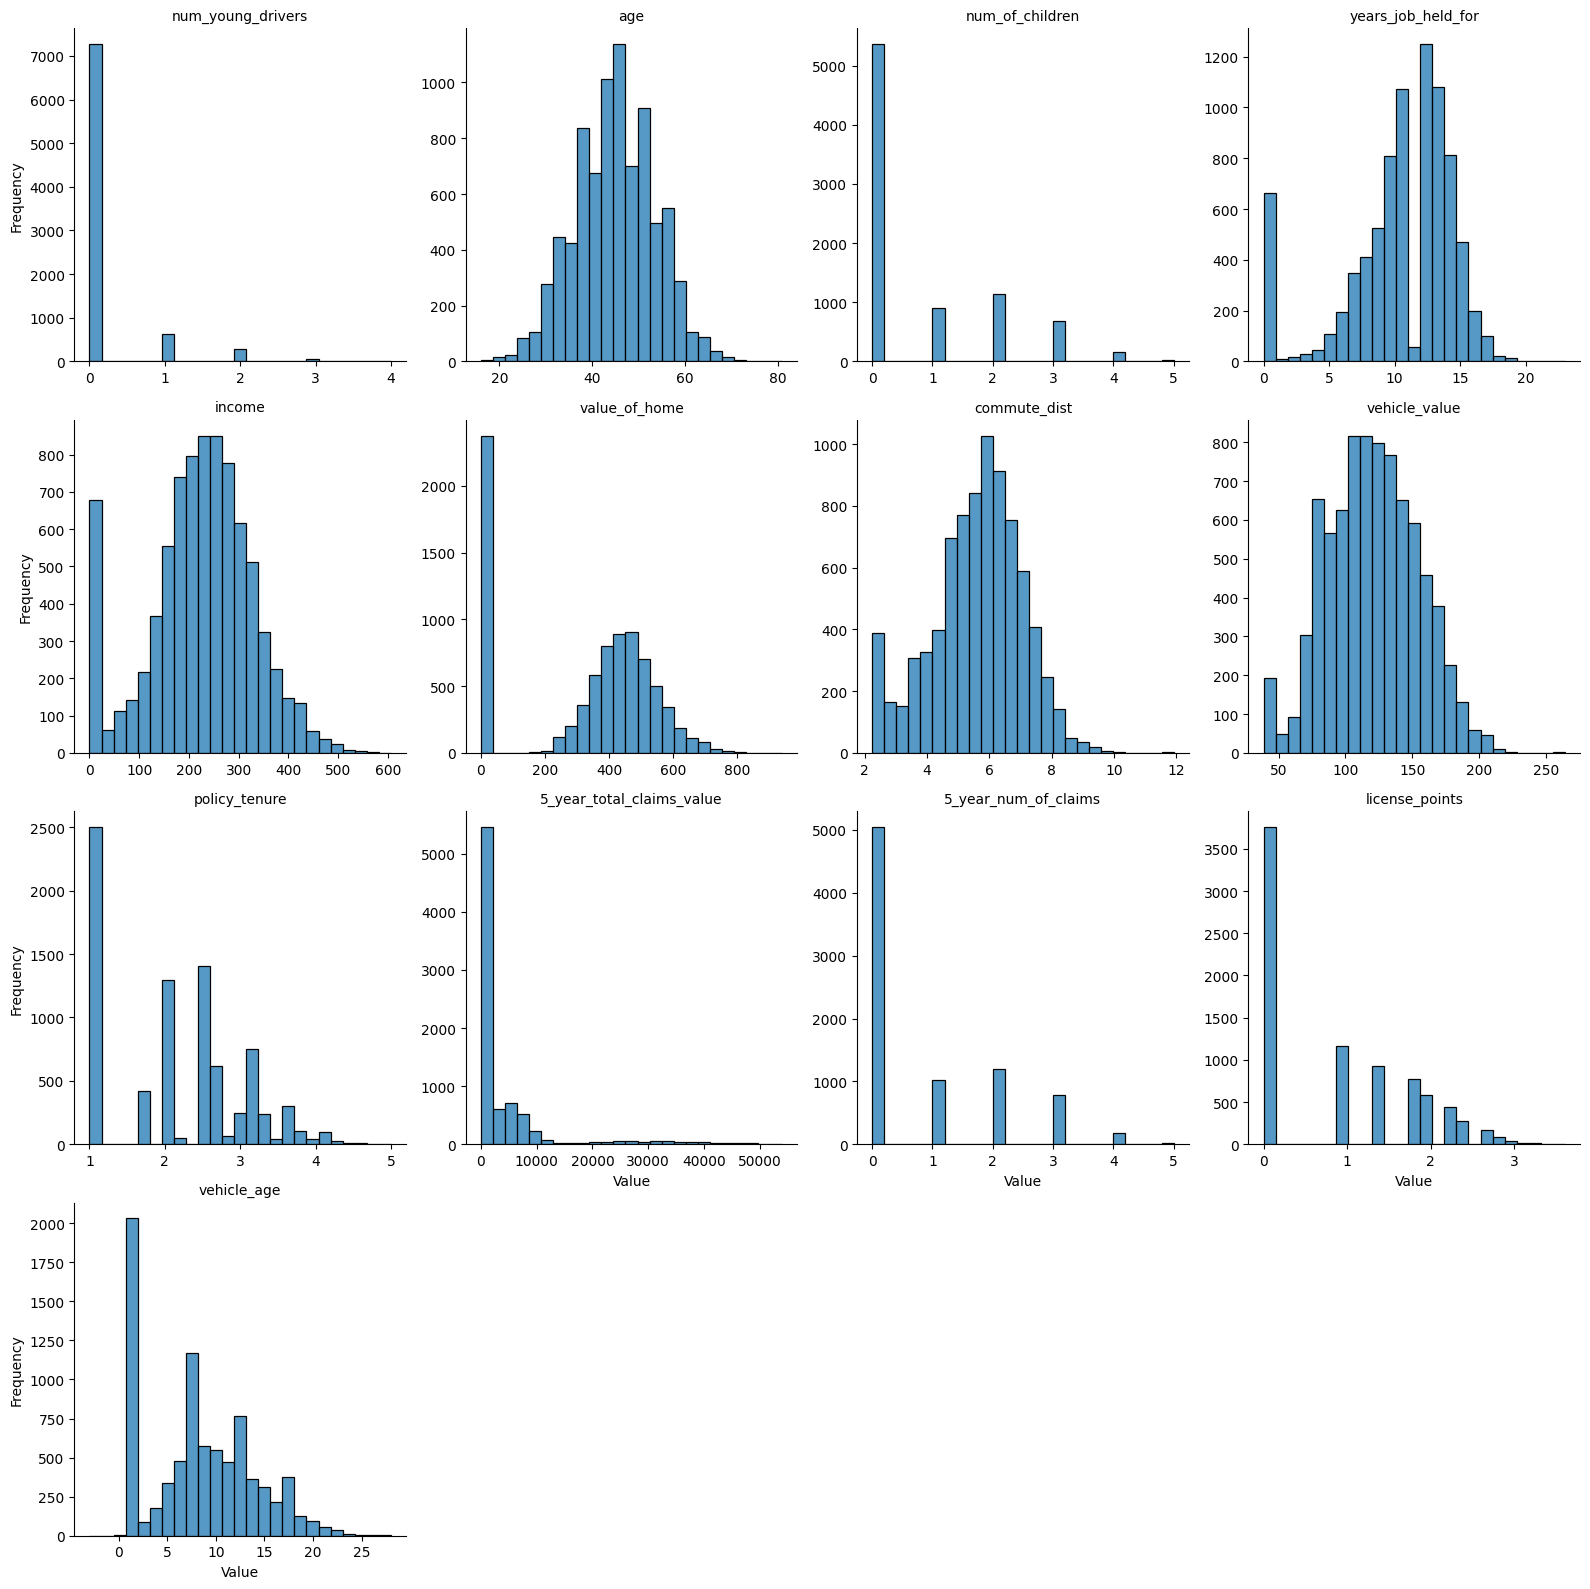

In [59]:
# Melt df to long format
melted_X_train = X_train_cleaned_sqrt[numerical_cols].melt(var_name = 'Column', value_name = 'Value')

# Create sns facetgrid
g = sns.FacetGrid(melted_X_train, col = 'Column', col_wrap = 4, sharex = False, sharey = False, height = 4)

# Map sns histoplot to each facet
g.map(sns.histplot, 'Value', bins = 25)

# Add titles and labels
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template = '{col_name}')

plt.tight_layout()

In [60]:
xgb_clf = XGBClassifier(random_state = 42)

# Check performance with cross-validation
cv_scores = cross_val_score(xgb_clf, X_train_cleaned, y_train, cv = kf)
cv_scores_sqrt = cross_val_score(xgb_clf, X_train_cleaned_sqrt, y_train, cv = kf)

print(f'CV score without sqrt transform : {cv_scores.mean()}')
print(f'CV score with sqrt transform: {cv_scores_sqrt.mean()}')

CV score without sqrt transform : 0.7770631067961167
CV score with sqrt transform: 0.7770631067961167


The transformation didn't cause anny affect on the results. However the scaling might benefit the regression models that we'll look at later. So since it had no negative effect we'll make sure t o build this into the model pipeline later.

##### Feature scaling


In [61]:
# Define function to scale numeric features
def scale_features(data_df, numeric_features):
    data = data_df.copy( )
    # Initialise scaler
    scaler = StandardScaler()
    # Fit scaler
    scaler.fit(data[numeric_features])
    # Tranform features
    data[numeric_features] = scaler.transform(data[numeric_features])
    return data

# Apply to X_train
X_train_cleaned_scaled = scale_features(X_train_cleaned_sqrt, numerical_cols)

In [62]:
xgb_clf = XGBClassifier(random_state = 42)

# Check performance with cross-validation
cv_scores = cross_val_score(xgb_clf, X_train_cleaned, y_train, cv = kf)
cv_scores_scaled = cross_val_score(xgb_clf, X_train_cleaned_scaled, y_train, cv = kf)

print(f'CV score without scaled transform : {cv_scores.mean()}')
print(f'CV score with scaled transform: {cv_scores_scaled.mean()}')

CV score without scaled transform : 0.7770631067961167
CV score with scaled transform: 0.7770631067961167


We can see that againt he score is the same, but also like before, since it had no negative effect and may benefit the regression models we'll scale the data in the model pipeline when we build it later.

In [63]:
X_train_cleanned = X_train_cleaned_scaled.copy()

### 7. Model Pipeline
#### 7.1 Custom Transformers

We'll create a new class called column dropper that will inherit the base estimator and tranformer mixing classes from scikt-learn in our definition. In the init definition we take columns to drop as a list and assign this as a variable to the object. We can then create the fit, tranform and get feature names out mathods

In [64]:
# Create transformer to drop red vehicle column
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return X.drop(columns = self.columns_to_drop)
    
    def get_feature_names_out(self, input_features = None):
        return None
    
    


In [68]:
# Transformer to take square root fo features
class SqrtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X[self.columns_to_transform] = np.sqrt(X[self.columns_to_transform])
        return X
    
    def get_feature_names_out(self, input_features = None):
        return input_features

7.2 Pipelines

In [72]:
from sklearn import set_config

# Set transformer outputs to panads dfs so we can reference column names
set_config(transform_output='pandas')

# Define column dropper pipeline
cols_to_drop_pipeline = Pipeline([
    ('col_dropper', ColumnDropper(cols_to_drop))
])

# Define skewed features
skewed_features = ['income', 'value_of_home', 'commute_dist', 'vehicle_value', 'policy_tenure', 'license_points']

# Define numerical feature pipeline
num_pipeline = Pipeline([
    ('knn_imputer', KNNImputer(n_neighbors = 2)),
    ('sqrt', SqrtTransformer(skewed_features)),
    ('scaler', StandardScaler())
])

# Define rank of education levels
education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# define ordinal categorical feature pipeline
cat_ord_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy = 'most_frequent')),
    ('ord_encoder', OrdinalEncoder(categories=education_rank))
])

# Define binary categorical feature pipeline
cat_bin_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy = 'most_frequent')),
    ('binary_encoder', OrdinalEncoder())
])

# Define one-hot categorical feature pipeline
cat_one_hot_pipeline = Pipeline([
    ('cat_simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output= False, drop = 'first'))
])


# Define preprocessing pipeline with a column transformer
preprocess_pipeline = ColumnTransformer([
    ('drop_features', cols_to_drop_pipeline, cols_to_drop),
    ('num', num_pipeline, numerical_cols),
    ('cat_ord', cat_ord_pipeline, cat_cols_ord),
    ('cat_bin', cat_bin_pipeline, cat_cols_bin),
    ('cat_one_hot', cat_one_hot_pipeline, cat_cols_one_hot)


])

In [73]:
# Let's see if the data frame that we created with the pipeline matches with the data that we created manul with pre-processing
# Transform X_train using the pipeline
X_train_prepared = preprocess_pipeline.fit_transform(X_train)

Check the pipeline output is correct by checking it against the Dataframe we built manually

In [75]:
# Create a df from the processed data
X_train_prepared_df = pd.DataFrame(
    X_train_prepared,
    columns = preprocess_pipeline.get_feature_names_out()
)

# Get names of the new one-hot columns
one_hot_col_names = list(preprocess_pipeline.transformers_[4][1][1].get_feature_names_out(cat_cols_one_hot))

# Create list of all column names
new_col_names = numerical_cols + cat_cols_ord + cat_cols_bin + one_hot_col_names

# Reset df columns
X_train_prepared_df.columns = new_col_names

# Reset index
X_train_prepared_df.reset_index( drop= True, inplace = True)

# Inpect of
X_train_prepared_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,-0.332668,1.409817,-0.643344,-2.563674,-0.375723,-1.452458,0.498062,-1.040804,1.139483,-0.461230,-0.691403,0.092242,-1.295667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3.669060,-0.453096,2.054902,0.874127,-0.866152,0.037836,-0.479232,-1.159364,-0.142286,-0.461230,-0.691403,0.878344,-1.295667,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.332668,-1.850281,1.155487,0.383013,0.090791,0.424047,0.443522,-2.392885,-0.142286,0.161972,0.177994,1.419574,-0.405338,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.332668,0.129064,0.256071,0.628570,0.258015,0.569484,-0.929180,0.845452,-1.245093,0.147137,0.177994,1.648754,-0.405338,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.332668,-0.685960,-0.643344,-0.599216,1.093996,1.062875,-0.409978,-1.374057,-1.245093,-0.461230,-0.691403,0.092242,-0.583403,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [78]:
# Inspect manually created df from earlier
X_train_cleanned.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,-0.332668,1.409817,-0.643344,-2.563674,-0.375723,-1.452458,0.498062,-1.040804,1.139483,-0.461230,-0.691403,0.092242,-1.295667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3.669060,-0.453096,2.054902,0.874127,-0.866152,0.037836,-0.479232,-1.159364,-0.142286,-0.461230,-0.691403,0.878344,-1.295667,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.332668,-1.850281,1.155487,0.383013,0.090791,0.424047,0.443522,-2.392885,-0.142286,0.161972,0.177994,1.419574,-0.405338,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.332668,0.129064,0.256071,0.628570,0.258015,0.569484,-0.929180,0.845452,-1.245093,0.147137,0.177994,1.648754,-0.405338,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.332668,-0.685960,-0.643344,-0.599216,1.093996,1.062875,-0.409978,-1.374057,-1.245093,-0.461230,-0.691403,0.092242,-0.583403,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [79]:
X_train_cleanned.equals(X_train_prepared_df)

True

Time to move on to hyperparameter tuning. We have our XGBoost model but this is currently just using the default parameter values. Let's see if we can improve the performance of this model by tuning the hyper parameter values. To cover a large parameter space we can first use the randomize search CV function, using random values from a defined range. If we can see an improvement in the model we can focus in on a smaller range of values using grid search. So first we need to define a parameter grid for the parameter values to try .   

### 8. Hyperparameter Optimisation

8.1 Random Search

In [84]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators' : randint(low = 50,high = 300),
    'learning_rate': uniform(0.01, 0.29),
    'max_depth': randint(low = 1, high = 20),
    'subsample' : uniform(0,1),
    'colsample_bytree': uniform(0,1),
    'min_child_weight' : randint(low = 1, high = 20),
    'reg_alpha': randint(low = 0, high = 100),
    'reg_lambda': randint(low = 0, high = 10),
    'gamma': uniform(0,1)
}

# Initialise the classfier
xgb_model = XGBClassifier(random_state = 42, eval_metric = 'error')

# Create random search with F1 score as the metric
scorer = make_scorer(f1_score, average = 'weighted')

random_search = RandomizedSearchCV(
    estimator = xgb_model,
    param_distributions = xgb_param_grid,
    n_iter = 2000,
    scoring = scorer,
    cv = 5,
    verbose = 1,
    random_state = 42,
    n_jobs = -1
)

In [85]:
# Fit the model using random search
random_search.fit(X_train_prepared, y_train)

# Print the best params and bestt score
print(f' best parameters found: { random_search.best_params_}')
print(f'best cross-validation score: {random_search.best_score_}')

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
 best parameters found: {'colsample_bytree': np.float64(0.9503797514820932), 'gamma': np.float64(0.9583276864813868), 'learning_rate': np.float64(0.03833510986215996), 'max_depth': 15, 'min_child_weight': 14, 'n_estimators': 294, 'reg_alpha': 0, 'reg_lambda': 8, 'subsample': np.float64(0.9860674802096018)}
best cross-validation score: 0.7848887763975866


In [90]:
# Define the parameter grid with expanded ranges
xgb_param_grid_grid_search = {
    'n_estimators' : [280,290,300],
    'max_depth': [6,7,8],
    'learning_rate': [0.03, 0.04, 0.05],
    'subsample' : [0.45, 0.5, 0.55],
    'colsample_bytree': [0.5,0.55,0.6],
    'min_child_weight' : [18],
    'reg_alpha': [1],
    'reg_lambda': [1],
    'gamma': [0.05, 0.1, 0.15]
}

# Initialise the classifier
xgb_model = XGBClassifier(random_state = 42, eval_metrics = 'error')

# Create grid search
scorer = make_scorer(f1_score, average = 'weighted')

grid_search = GridSearchCV(
    estimator = xgb_model,
    param_grid = xgb_param_grid_grid_search,
    scoring=scorer,
    cv = 5,
    verbose = 1,
    n_jobs = -1
)

In [91]:
# Fit the model using the grid search
grid_search.fit(X_train_prepared, y_train)

# Print the best params and best score
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_}')

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


c:\Users\erika\anaconda3\envs\dsa\Lib\site-packages\xgboost\training.py:183: UserWarning:

[08:25:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "eval_metrics" } are not used.




Best parameters found: {'colsample_bytree': 0.5, 'gamma': 0.05, 'learning_rate': 0.04, 'max_depth': 8, 'min_child_weight': 18, 'n_estimators': 280, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.45}
Best cross-validation score: 0.7854672457128494


In [92]:
# Compare initial score and tuned score
print(f'Default hyperparameters score: {cv_scores.mean()}')
print(f'Tuned hyperparameters score : {grid_search.best_score_}')

Default hyperparameters score: 0.7770631067961167
Tuned hyperparameters score : 0.7854672457128494


At this point we are now ready to make our predictions on the test set. We first need to pre-process the X test set with out pipeline

#### 9. Model Evaluation

In [93]:
# Prepare test set using pipeline
X_test_prepared = preprocess_pipeline.fit_transform(X_test)

# Predict y_test values using the best model from the grid search
y_pred = grid_search.best_estimator_.predict(X_test_prepared)

In [95]:
# Check f1 score of predictions
f1_score(y_test, y_pred, average = 'weighted')

0.7659841525866742

We can use confision matrix to better understand the predictions that our model is making

Text(0.5, 1.0, 'Confision Matrix')

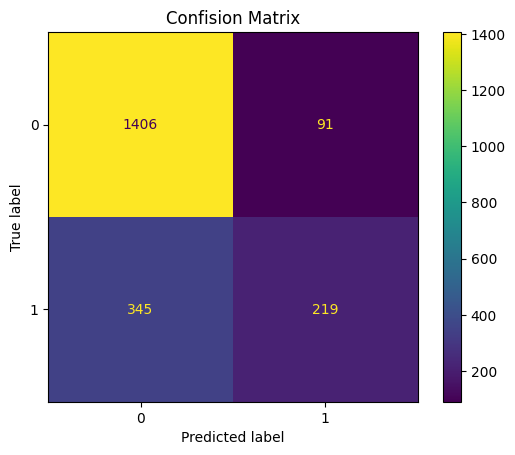

In [96]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred )

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confision Matrix')

We can now see that our model made 1406 true negative predictions and 219 true positive predictions. The model biggest weakness was false negatives it predicted 345 of it. So now we can see there's still some room for improvement. We could look at going further with feature engineering or Ensemble methods combinins different models.

#### 1. Regression
10.1 train/Test Sets

Just to remind you, we can use the regression model to predict the value of a claim

In [97]:
# Filter to only rows with a non-zero claim value
claim_data = data_df[data_df['new_claim_value'] > 0]

# Create clean copy of training data
X_reg = claim_data.copy()
y_reg = claim_data['new_claim_value']

# Drop the target feature from X
X_reg.drop(columns = ['new_claim_value', 'is_claim', 'claim_value_cat'], inplace = True)

# Create train/test split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state = 42)

In [104]:
# Use the same pipeline as the classifier to preprocess X train
X_reg_train_prepaerd = preprocess_pipeline.fit_transform(X_reg_train)

10.2 Model Selection


In [98]:
regs = [
        ('Linear Regression', LinearRegression()),
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=25, solver='sag', tol=3)),
    ('SGD Regressor', SGDRegressor(random_state=42)),
    ('Decision Tree Regression ', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('KNN Model ', KNeighborsRegressor()),
    ('Support Vector Machines (SVM)', SVR(gamma=2, C=1)),
    ('XGBRegressor', XGBRegressor(random_state=42))
]

In [107]:
# Create KFold object with 10 folds
reg_kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

# Dictionay to store cv results
req_results = {}

# Evaluate each reg model using cross-validation
for reg_name, reg in regs:
    cv_rnses = -cross_val_score(reg, X_reg_train_prepaerd,y_reg_train, cv = reg_kf, scoring = 'neg_root_mean_squared_error')
    req_results[reg_name] = cv_rnses

# Convert dictionay to a df
reg_cv_scores_df = pd.DataFrame(req_results)

A good performance measure for regression problems is the Root mean squared error (RMSE), and is also more sensitive to outliers than other metrics like the mean absolute error(MAE)

Text(0.5, 1.0, 'Cross-Validation Scores for Different Regressors')

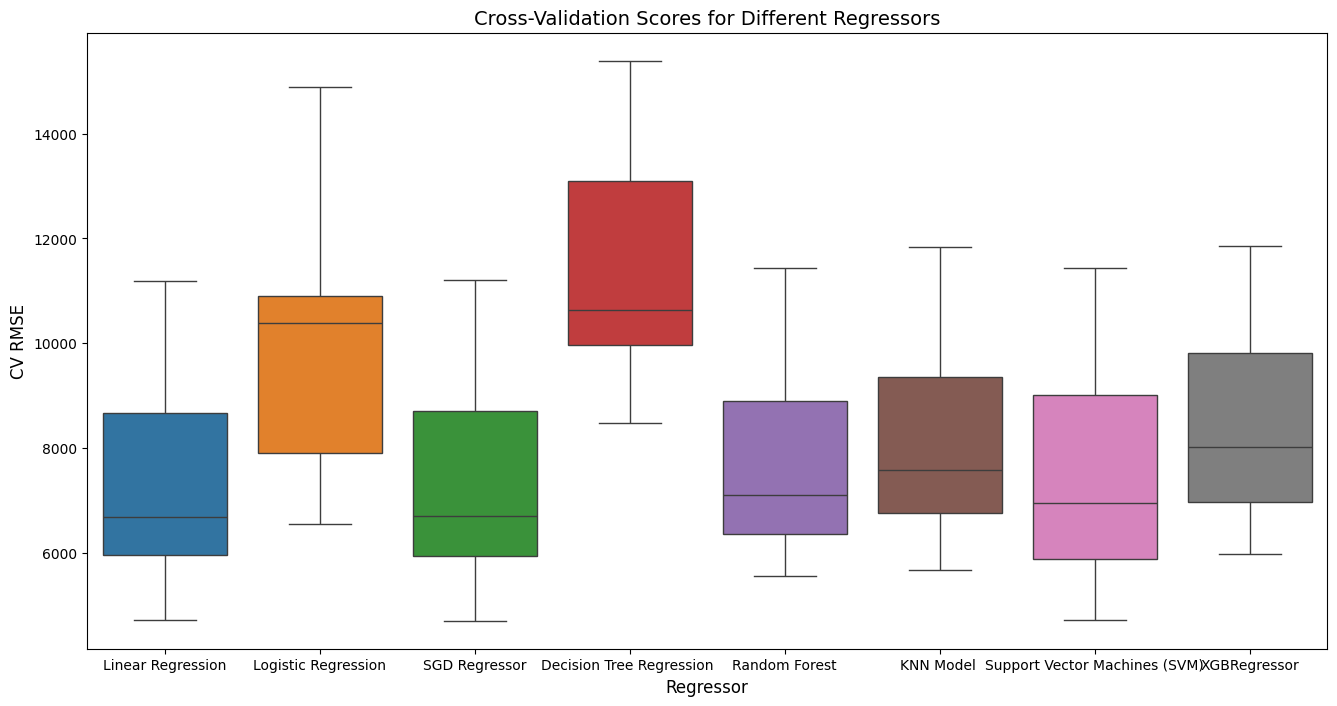

In [108]:
# Again, create box plot of cv scores
fig, ax = plt.subplots(figsize = (16,8))
sns.boxplot(reg_cv_scores_df)

# Add labels and title
ax.set_xlabel('Regressor', fontsize = 12)
ax.set_ylabel('CV RMSE', fontsize = 12                )
ax.set_title('Cross-Validation Scores for Different Regressors', fontsize = 14)



We can actually see that linear regression and SGD regressor models we the best on average as they both had the smallest RMSSE of around 6700. It make sense since both models perform similarly as they're very similar interms of teh algorithms. As the SGD regressor has more hyperparameters that we can look at tuning, we'll proceed with using that.


#### 10.3 Hyperparameter Optimisation

In [114]:
# Define the parameter grid for random search
reg_param_grid = {
    'penalty' : ['l2', 'l1', 'elasticnet'],
    'alpha' : uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'invscaling'],
    'eta0': uniform(0.001,0.1),
    'max_iter' : randint(100, 1000),
    'tol' :  uniform(1e-6, 1e-3)
}

# Initialise the model
sgd_regressor = SGDRegressor(random_state = 42)

# Create random search
reg_random_search = RandomizedSearchCV(
    estimator = sgd_regressor,
    param_distributions = reg_param_grid,
    n_iter = 500,
    scoring = 'neg_mean_squared_error',
    cv = reg_kf,
    verbose = 1,
    random_state = 42,
    n_jobs = -1
)



In [115]:
# Fit the model
reg_random_search.fit(X_reg_train_prepaerd, y_reg_train)

# Crete score
score = np.sqrt(-reg_random_search.best_score_)

# Print best params and score
print(f'Best parameters found: {reg_random_search.best_params_}')
print(f'Best cross-validation score: {score}')

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Best parameters found: {'alpha': np.float64(0.008548753109694546), 'eta0': np.float64(0.003327193573582587), 'learning_rate': 'invscaling', 'max_iter': 214, 'penalty': 'l2', 'tol': np.float64(0.0004970374542934063)}
Best cross-validation score: 7606.542104820654


In [116]:
reg_param_grid_grid_search = {
    'penalty' : ['l2'],
    'alpha' : [0.004,0.008,0.012],
    'learning_rate': [ 'invscaling'],
    'eta0': [0.001,0.003,0.005],
    'max_iter' : [180,200, 220],
    'tol' :  [1e-5, 1e-4, 1e-6]
}

# initialise the model
sgd_regressor = SGDRegressor(random_state = 42)

# Create grid search
reg_grid_search = GridSearchCV(
    estimator=sgd_regressor,
    param_grid = reg_param_grid_grid_search,
    scoring = 'neg_mean_squared_error',
    cv = reg_kf,
    verbose = 1,
    n_jobs = -1
)

In [117]:
# Fit the model
reg_grid_search.fit(X_reg_train_prepaerd, y_reg_train)

# Create score
reg_score = np.sqrt(-reg_grid_search.best_score_)

# Print best parameters and best score
print(f'Best parameters: {reg_grid_search.best_params_}')
print(f'Best cross-validation score: {reg_score}')

Fitting 10 folds for each of 81 candidates, totalling 810 fits
Best parameters: {'alpha': 0.012, 'eta0': 0.003, 'learning_rate': 'invscaling', 'max_iter': 180, 'penalty': 'l2', 'tol': 1e-05}
Best cross-validation score: 7605.2923588743715


10.4 Model Evaluation

In [118]:
# Prepare X_test using our preprocessing pipeline
X_reg_test_prepared = preprocess_pipeline.fit_transform(X_reg_test)

# Predict y using the best regression model
y_reg_pred = reg_grid_search.best_estimator_.predict(X_reg_test_prepared)

In [122]:
# Create scores

# Mean squared error
mse = mean_squared_error(y_reg_test, y_reg_pred)

# Root mean squared error
rmse = np.sqrt(mse)

# mean absolute error
mae = mean_absolute_error(y_reg_test, y_reg_pred)

print(f'RMSE: {rmse}')
print(f'MAE  : {mae}')

RMSE: 8378.846093356431
MAE  : 3556.2627508324217


There's a lot more opportunituies to improve this. You could look at feature engineering. Ensemble methods, investigating feature importances and that's just a name of a few